In [1]:
import matplotlib.pyplot as plt 
import numpy as np 
import glob
import re
import datetime 

import sunpy.map 
from sunpy.coordinates import frames, get_body_heliographic_stonyhurst

from aiapy.calibrate import register, update_pointing, normalize_exposure

from astropy import units as u 
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS

from reproject import reproject_interp
from reproject.mosaicking import reproject_and_coadd

import warnings
warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = (16, 8)

In [317]:
stereo_files = glob.glob("./stereo_files/*.fts"); stereo_files.sort()
aia_304_files = glob.glob("./aia_files/*304*.fits"); aia_304_files.sort()
aia_1700_files = glob.glob("./aia_files/*1700*.fits"); aia_1700_files.sort()
print(len(stereo_files))

11


In [318]:
def find_file_times(file_name):
    t = re.search('\d{8}_\d{6}', file_name)
    if t is None:
        t = re.search("\d{4}_\d{2}_\d{2}t\d{2}_\d{2}_\d{2}", file_name)
        return datetime.datetime.strptime(t.group(), '%Y_%m_%dt%H_%M_%S')
    else:
        tt = datetime.datetime.strptime(t.group(), '%Y%m%d_%H%M%S')
        return tt

In [319]:
stereo_file_times = np.array([find_file_times(f) for f in stereo_files])
aia_file_times = np.array([find_file_times(f) for f in aia_304_files])
aia_file_times_1700 = np.array([find_file_times(f) for f in aia_1700_files])

In [343]:
stereo_file_times[0]

datetime.datetime(2014, 2, 25, 0, 46, 15)

In [320]:
indices = np.array([np.argmin(np.abs(aia_file_times - t)) for t in stereo_file_times])
indices_1700 = np.array([np.argmin(np.abs(aia_file_times_1700 - t)) for t in stereo_file_times])

In [322]:
matching_aia_files = np.array(aia_304_files)[indices]
matching_aia_1700_files = np.array(aia_1700_files)[indices_1700]

In [7]:
aia_maps = sunpy.map.Map(list(matching_aia_files))
stereo_maps = sunpy.map.Map(stereo_files)

In [8]:
def aia_prep(maps):
    new_maps = []
    for m in maps:
        m_updated_pointing = update_pointing(m)
        m_registered = register(m_updated_pointing)
        m_normalized = normalize_exposure(m_registered)
        new_maps.append(m_normalized)
    return new_maps

In [9]:
# aia_maps_prep = aia_prep(aia_maps)

In [10]:
def plot_both(i=0):
    fig = plt.figure(figsize=(11, 5))
    ax1 = fig.add_subplot(1, 2, 1, projection=aia_maps_prep[i])
    ax2 = fig.add_subplot(1, 2, 2, projection=stereo_maps[i])
    aia_maps_prep[i].plot(clip_interval=[1, 99.9]*u.percent, axes=ax1)
    stereo_maps[i].plot(clip_interval=[1, 99.9]*u.percent, axes=ax2)

In [12]:
print(aia_304_files[45])
print(stereo_files[1])

./aia_files/aia_lev1_304a_2014_02_25t00_48_10_27z_image_lev1.fits
./stereo_files/20140225_004845_n5eub.fts


## Lets now reproject to new observation

In [380]:
map_aia = sunpy.map.Map(matching_aia_files[0])
map_euvi = sunpy.map.Map(stereo_files[0])
map_aia1700 = sunpy.map.Map(aia_1700_files[22])
print(map_aia.data.shape, map_euvi.data.shape)

print(map_aia.date.datetime, map_euvi.date.datetime, map_aia1700.date.datetime)

(4096, 4096) (2048, 2048)
2014-02-25 00:46:19.120000 2014-02-25 00:47:10.766000 2014-02-25 00:48:06.720000


In [381]:
aia_304_files[40]

'./aia_files/aia_lev1_304a_2014_02_25t00_47_07_12z_image_lev1.fits'

In [382]:
test_coord = SkyCoord(-85.066*u.deg, 7.183*u.deg, map_aia.observer_coordinate.radius,
                      frame="heliographic_stonyhurst",
                      obstime=map_aia.date)

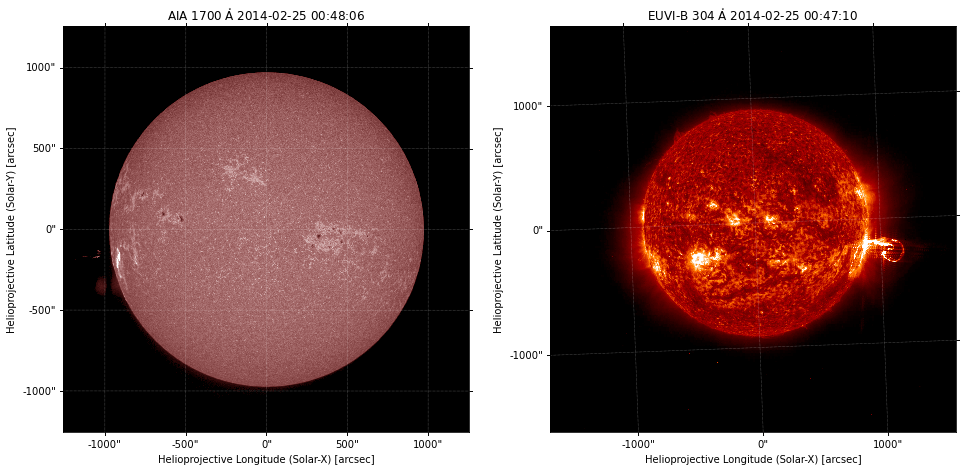

In [383]:
fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1, projection=map_aia1700)
map_aia1700.plot(axes=ax1, vmin=100)
ax2 = fig.add_subplot(1, 2, 2, projection=map_euvi)
map_euvi.plot(axes=ax2, clip_interval=[1, 99.9]*u.percent)

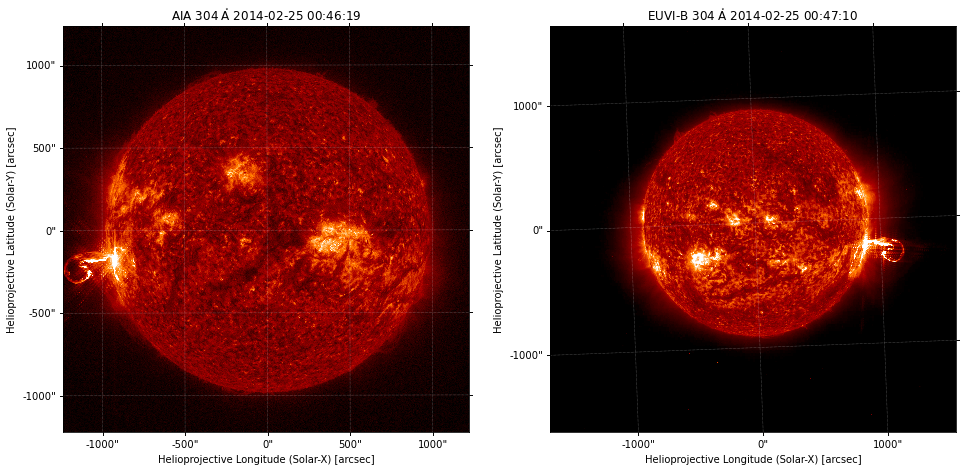

In [376]:
fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1, projection=map_aia)
map_aia.plot(axes=ax1, clip_interval=[1, 99.9]*u.percent)
ax2 = fig.add_subplot(1, 2, 2, projection=map_euvi)
map_euvi.plot(axes=ax2, clip_interval=[1, 99.9]*u.percent)

In [377]:
mars_ref_coord = SkyCoord(map_aia.reference_coordinate.Tx,
                          map_aia.reference_coordinate.Ty,
                          obstime=map_aia.reference_coordinate.obstime,
                          observer=test_coord,
                          frame="helioprojective")

In [439]:
out_shape=(1024, 1024)

map_aia = map_aia.resample(out_shape * u.pix)
map_euvi = map_euvi.resample(out_shape * u.pix)

map_aia1700 = map_aia1700.resample(out_shape * u.pix)
mars_header = sunpy.map.make_fitswcs_header(out_shape,
                                            mars_ref_coord,
                                            scale=u.Quantity(map_aia.scale),
                                            rotation_matrix=map_aia.rotation_matrix,
                                            instrument="AIA",
                                            wavelength=map_aia.wavelength)

In [440]:
map_aia2 = sunpy.map.Map(29.63* map_aia.data/map_aia.exposure_time.value, map_aia.meta)
map_euvi2 = sunpy.map.Map(map_euvi.data/map_euvi.exposure_time.value, map_euvi.meta)

In [446]:
mars_wcs = WCS(mars_header)
from reproject.mosaicking import reproject_and_coadd
import numpy as np 

coordinates = tuple(map(sunpy.map.all_coordinates_from_map, [map_aia2, map_euvi]))
weights = [coord.transform_to("heliocentric").z.value for coord in coordinates]

weights = [(w / np.nanmax(w)) ** 3 for w in weights]
for w in weights:
    w[np.isnan(w)] = 0


output1, footprint1 = reproject_and_coadd([map_euvi], mars_wcs, out_shape, 
                                        reproject_function=reproject_interp)

output2, footprint2 = reproject_and_coadd([map_aia], mars_wcs, out_shape, 
                                        reproject_function=reproject_interp)


output3, footprint3 = reproject_and_coadd([map_aia2, map_euvi2], mars_wcs, out_shape,
                                        reproject_function=reproject_interp)

output4, footprint4 = reproject_and_coadd([map_aia1700], mars_wcs, out_shape,
                                        reproject_function=reproject_interp)


output5, footprint5 = reproject_and_coadd([ map_euvi, map_aia1700], mars_wcs, out_shape,
                                        reproject_function=reproject_interp)





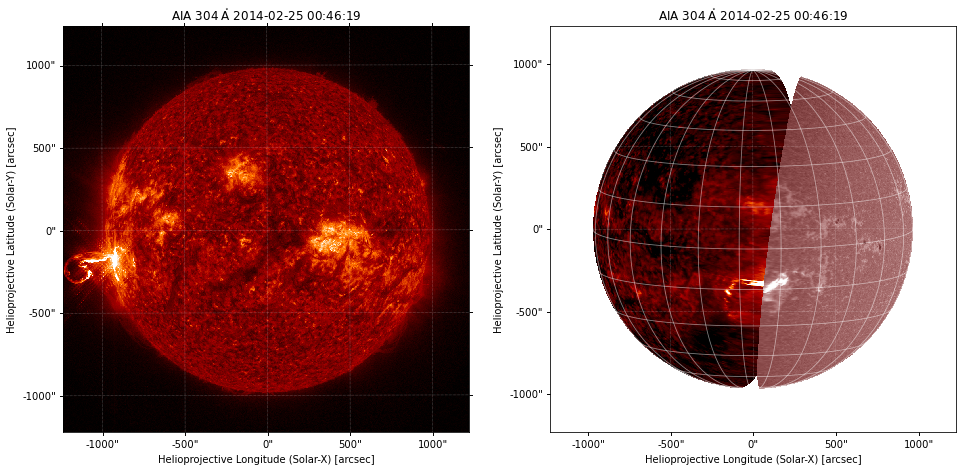

In [447]:
outmap1 = sunpy.map.Map((output1, mars_header))
outmap2 = sunpy.map.Map((output2, mars_header))
outmap4 = sunpy.map.Map((output4, mars_header))
outmap5 = sunpy.map.Map((output5, mars_header))

outmap_full = sunpy.map.Map((output3, mars_header))

outmap1.plot_settings = map_euvi.plot_settings
outmap2.plot_settings = map_aia.plot_settings
outmap4.plot_settings = map_aia1700.plot_settings
outmap_full.plot_settings = map_aia.plot_settings


fig = plt.figure()

ax1 = fig.add_subplot(1, 2, 1, projection=map_aia)
map_aia.plot(axes=ax1, clip_interval=[1, 99.9]*u.percent)
# outmap.draw_grid(color='w')

ax2 = fig.add_subplot(1, 2, 2, projection=outmap1)
outmap1.plot(axes=ax2, title='AIA and EUVI observation as seen from New Coord', clip_interval=[1, 99.9]*u.percent)
# outmap2.plot(axes=ax2, clip_interval=[1, 99.5]*u.percent)
outmap4.plot(axes=ax2, vmin=100)
outmap1.draw_grid(color='w')

plt.show()

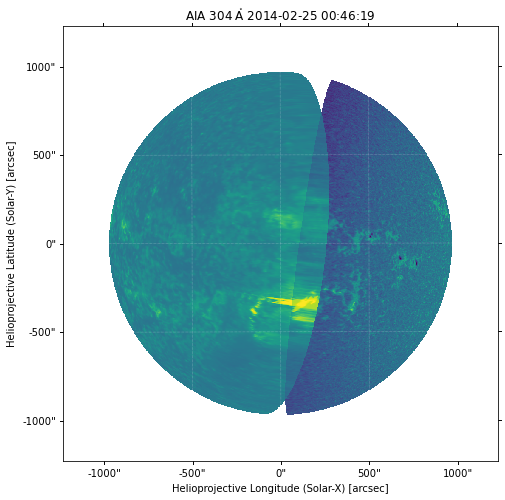

In [449]:
outmap5.plot(cmap="viridis")

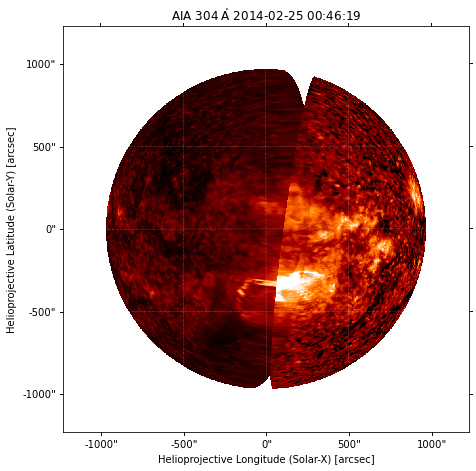

In [52]:
fig = plt.figure()

ax1 = fig.add_subplot(1, 2, 1, projection=outmap_full)
outmap_full.plot(axes=ax1, clip_interval=[1, 99.5]*u.percent)
plt.show()

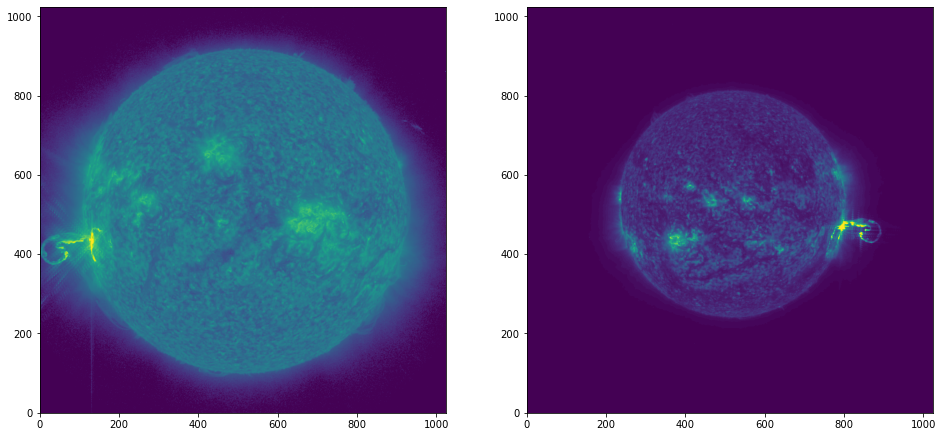

In [66]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(bytescale(np.log10(map_aia.data), cmin=0, cmax=4), origin="lower")
ax[1].imshow(bytescale(np.log10(map_euvi.data), cmin=-1, cmax=4), origin="lower")

In [46]:
# Returns a byte-scaled image
def bytescale(data, cmin=None, cmax=None, high=255, low=0):
    """
    Byte scales an array (image).

    Byte scaling means converting the input image to uint8 dtype and scaling
    the range to ``(low, high)`` (default 0-255).
    If the input image already has dtype uint8, no scaling is done.

    Parameters
    ----------
    data : ndarray
        PIL image data array.
    cmin : scalar, optional
        Bias scaling of small values. Default is ``data.min()``.
    cmax : scalar, optional
        Bias scaling of large values. Default is ``data.max()``.
    high : scalar, optional
        Scale max value to `high`.  Default is 255.
    low : scalar, optional
        Scale min value to `low`.  Default is 0.

    Returns
    -------
    img_array : uint8 ndarray
        The byte-scaled array.

    Examples
    --------
    >>> img = array([[ 91.06794177,   3.39058326,  84.4221549 ],
                     [ 73.88003259,  80.91433048,   4.88878881],
                     [ 51.53875334,  34.45808177,  27.5873488 ]])
    >>> bytescale(img)
    array([[255,   0, 236],
           [205, 225,   4],
           [140,  90,  70]], dtype=uint8)
    >>> bytescale(img, high=200, low=100)
    array([[200, 100, 192],
           [180, 188, 102],
           [155, 135, 128]], dtype=uint8)
    >>> bytescale(img, cmin=0, cmax=255)
    array([[91,  3, 84],
           [74, 81,  5],
           [52, 34, 28]], dtype=uint8)

    """
    if data.dtype == np.uint8:
        return data

    if high < low:
        raise ValueError("`high` should be larger than `low`.")

    if cmin is None:
        cmin = data.min()
    if cmax is None:
        cmax = data.max()

    cscale = cmax - cmin
    if cscale < 0:
        raise ValueError("`cmax` should be larger than `cmin`.")
    elif cscale == 0:
        cscale = 1

    scale = float(high - low) / cscale
    bytedata = (data * 1.0 - cmin) * scale + 0.4999
    bytedata[bytedata > high] = high
    bytedata[bytedata < 0] = 0
    return np.cast[np.uint8](bytedata) + np.cast[np.uint8](low)

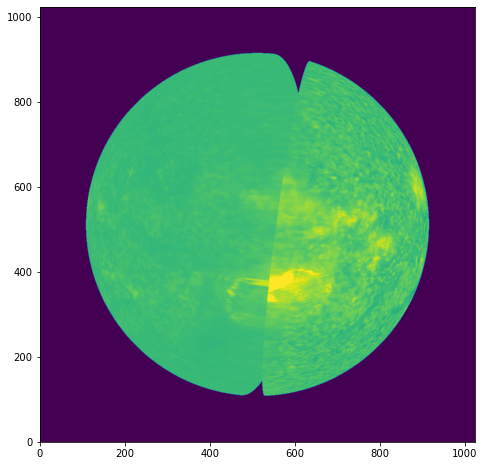

In [69]:
plt.imshow(bytescale(np.log10(outmap_full.data), -1, 4), origin="lower")

In [90]:
def get_car_map(aia_file, stereo_file, res=1):
    
    maps = sunpy.map.Map([aia_file, stereo_file])

    if maps[0].detector == "AIA":
        maps[0] = sunpy.map.Map(26*maps[0].data/maps[0].exposure_time.value, maps[0].meta)
    
    maps = [m.resample((512, 512)*u.pix) for m in maps]

    shape_out = (180*res, 360*res)  
    
    header = sunpy.map.make_fitswcs_header(shape_out,
                                           SkyCoord(0, 0, unit=u.deg,
                                                    frame=frames.HeliographicStonyhurst,
                                                    obstime=maps[0].date),
                                           scale=[180 / shape_out[0],
                                                  360 / shape_out[1]] * u.deg / u.pix,
                                           wavelength=int(maps[0].meta['wavelnth']) * u.AA,
                                           projection_code="CAR")
    out_wcs = WCS(header)
    
    coordinates = tuple(map(sunpy.map.all_coordinates_from_map, maps))
    weights = [coord.transform_to("heliocentric").z.value for coord in coordinates]
    
    weights = [(w / np.nanmax(w)) ** 3 for w in weights]
    for w in weights:
        w[np.isnan(w)] = 0
    
    array, _ = reproject_and_coadd(maps, out_wcs, shape_out,
                                   input_weights=weights,
                                   reproject_function=reproject_interp,
                                   match_background=True,
                                   background_reference=0)

    outmap = sunpy.map.Map((array, header))

    return outmap


In [91]:
testy = get_car_map(matching_aia_files[0], stereo_files[0])

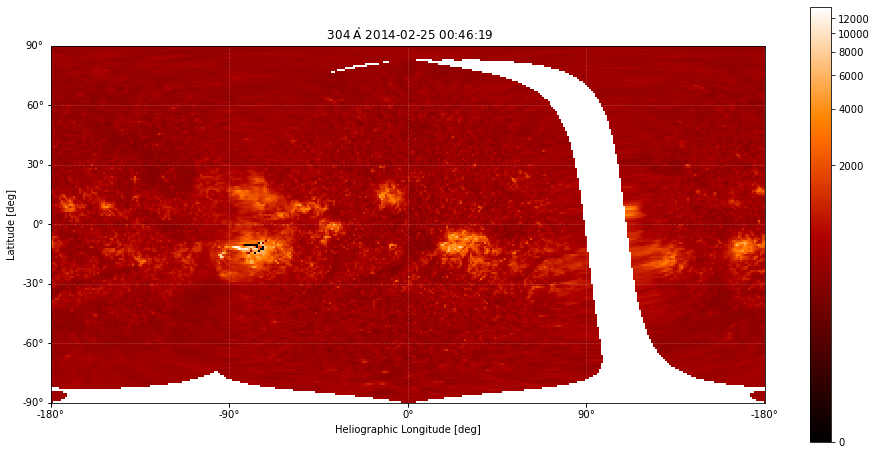

In [92]:
testy.plot_settings = aia_maps[0].plot_settings
testy.plot(vmin=0)
plt.colorbar()

## Lets now plot AIA limb on STEREO-EUVI map

In [94]:
maps = {m.detector: m.submap(SkyCoord([-1100, 1100], [-1100, 1100],
                                      unit=u.arcsec, frame=m.coordinate_frame))
        for m in [map_aia, map_euvi]}

In [469]:
r = maps['AIA'].rsun_obs - 1 * u.arcsec  # remove one arcsec so it's on disk.
# Adjust the following range if you only want to plot on STEREO_A
th = np.linspace(-90 * u.deg, -130 * u.deg)
x = r * np.sin(th)
y = r * np.cos(th)
coords = SkyCoord(x, y, frame=maps['AIA'].coordinate_frame)

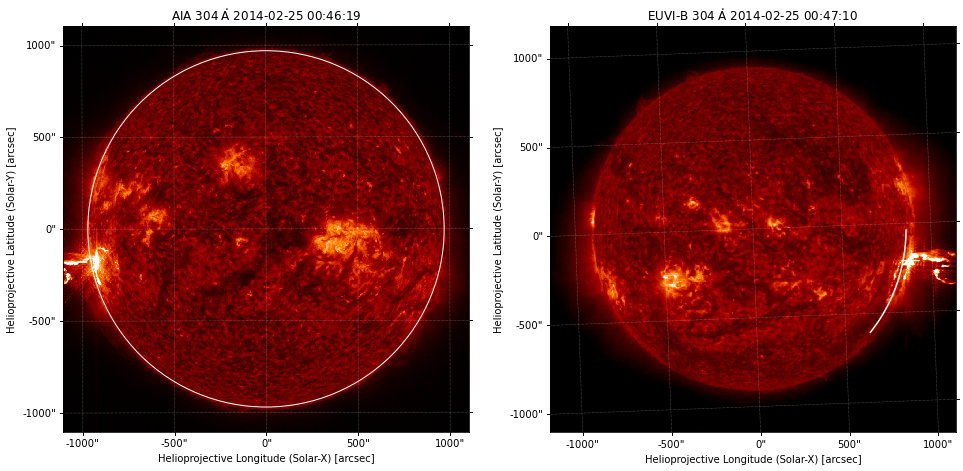

In [470]:
fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1, projection=maps['AIA'])
maps['AIA'].plot(axes=ax1, clip_interval=[1, 99.9]*u.percent)
maps['AIA'].draw_limb()

ax2 = fig.add_subplot(1, 2, 2, projection=maps['EUVI'])
maps['EUVI'].plot(axes=ax2, clip_interval=[1, 99.9]*u.percent)

ax2.plot_coord(coords, color='w')

In [184]:
bl_aia = SkyCoord(-1000*u.arcsec, -500*u.arcsec, frame=map_aia.coordinate_frame, 
                  distance=map_aia.observer_coordinate.radius)
width = 200*u.arcsec
height = 500*u.arcsec
corners_aia = ([bl_aia.Tx, bl_aia.Ty],
               [bl_aia.Tx + width, bl_aia.Ty],
               [bl_aia.Ty, bl_aia.Ty + height],
               [bl_aia.Tx + width, bl_aia.Ty + height])

corners_aia = SkyCoord(corners_aia, frame=map_aia.coordinate_frame, distance=map_aia.observer_coordinate.radius)

#the coordinates of the corners now in STEREO/EUVI coordinate system
corners_stereo = corners_aia.transform_to(map_euvi.coordinate_frame)

In [192]:
corners_stereo

<SkyCoord (Helioprojective: obstime=2014-02-25T00:47:10.766, rsun=695700000.0 m, observer=<HeliographicStonyhurst Coordinate (obstime=2014-02-25T00:47:10.766): (lon, lat, radius) in (deg, deg, m)
    (-160.13335741, 7.23745837, 1.59780991e+11)>): (Tx, Ty, distance) in (arcsec, arcsec, m)
    [(854.05655549, -503.37631587, 1.59545857e+11),
     (679.02652919, -495.27338327, 1.59593178e+11),
     (436.26548481,  -19.8670308 , 1.59660685e+11),
     (698.51889938,  -31.80472136, 1.59589239e+11)]>

In [186]:
point_aia = SkyCoord(-1155*u.arcsec, -250*u.arcsec, frame=map_aia.coordinate_frame, distance=map_aia.observer_coordinate.radius)

point_stereo = point_aia.transform_to(map_euvi.coordinate_frame)
print(point_stereo)

<SkyCoord (Helioprojective: obstime=2014-02-25T00:47:10.766, rsun=695700000.0 m, observer=<HeliographicStonyhurst Coordinate (obstime=2014-02-25T00:47:10.766): (lon, lat, radius) in (deg, deg, m)
    (-160.13335741, 7.23745837, 1.59780991e+11)>): (Tx, Ty, distance) in (arcsec, arcsec, m)
    (999.52582868, -277.80603567, 1.59507178e+11)>


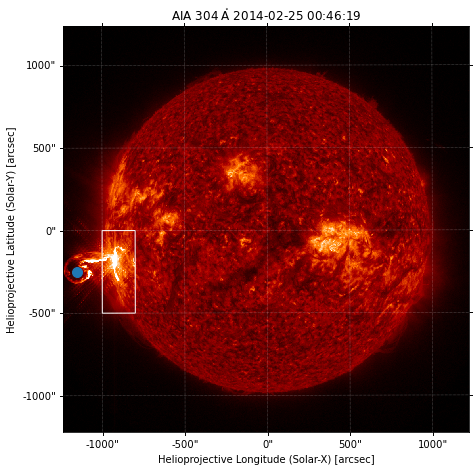

In [187]:
fig = plt.figure()
ax = plt.subplot(1,2,1, projection=map_aia)
map_aia.plot(axes=ax, clip_interval=(1, 99.9)*u.percent)

map_aia.draw_rectangle(corners_aia[0], 
                       width=corners_aia[1].Tx - corners_aia[0].Tx, 
                       height=corners_aia[2].Ty - corners_aia[0].Ty)

ax.plot_coord(point_aia, color="tab:blue", marker='o', ms=10)

In [188]:
point_stereo.Tx

<Longitude 999.52582868 arcsec>

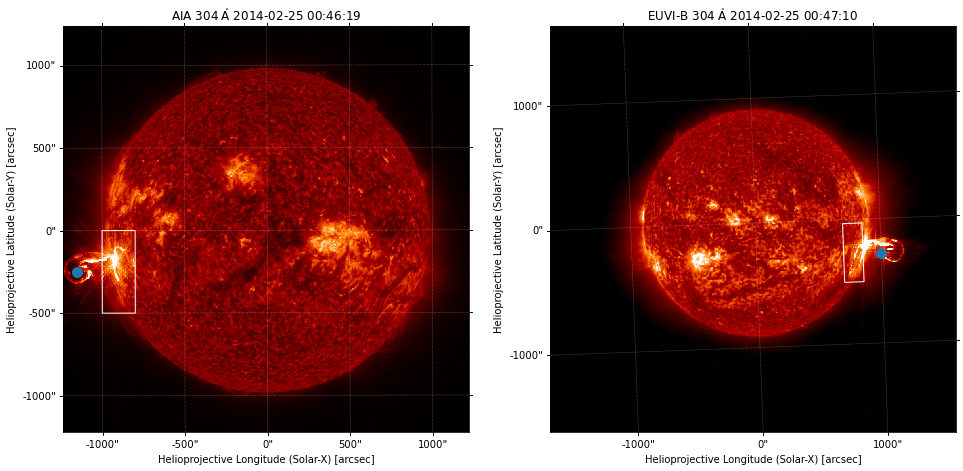

In [201]:
fig = plt.figure()
ax = plt.subplot(1,2,1, projection=map_aia)
map_aia.plot(axes=ax, clip_interval=(1, 99.9)*u.percent)
map_aia.draw_rectangle(corners_aia[0], 
                       width=corners_aia[1].Tx - corners_aia[0].Tx, 
                       height=corners_aia[2].Ty - corners_aia[0].Ty)
ax.plot_coord(point_aia, color="tab:blue", marker='o', ms=10)

ax2 = plt.subplot(1,2,2, projection=map_euvi)
map_euvi.plot(axes=ax2, clip_interval=(1, 99.9)*u.percent)
# map_euvi.draw_rectangle(corners_stereo[0], 
#                         width=np.abs(corners_stereo[1].Tx - corners_stereo[0].Tx), 
#                         height=np.abs(corners_stereo[2].Ty - corners_stereo[0].Ty), color="w")

map_euvi.draw_rectangle(corners_stereo[0], top_right=corners_stereo[3], color="w")

ax2.plot_coord(point_stereo, color="tab:blue", marker='o', ms=10)

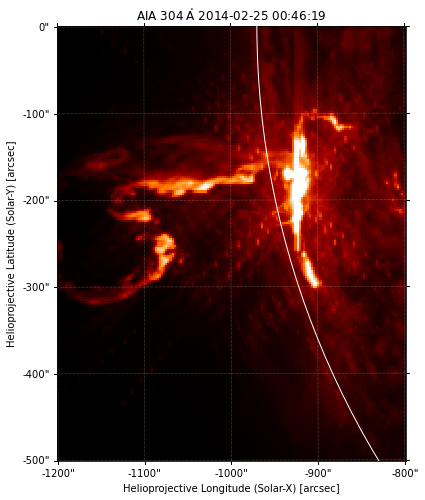

In [214]:
submap_aia = map_aia.submap(SkyCoord(-1200*u.arcsec, -500*u.arcsec, frame=map_aia.coordinate_frame), 
                            top_right=SkyCoord(-800*u.arcsec, 0*u.arcsec, frame=map_aia.coordinate_frame))
submap_aia.plot(clip_interval=(1, 99.5)*u.percent)
submap_aia.draw_limb()

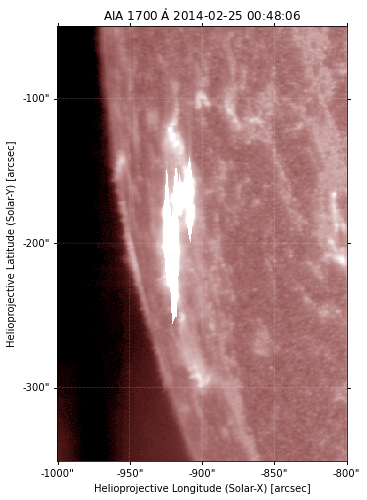

In [387]:
submap_aia1700 = map_aia1700.submap(SkyCoord(-1000*u.arcsec, -350*u.arcsec, frame=map_aia1700.coordinate_frame), 
                            top_right=SkyCoord(-800*u.arcsec, -50*u.arcsec, frame=map_aia1700.coordinate_frame))
submap_aia1700.plot(vmin=100, vmax=10000)
# submap_aia1700.draw_limb(color="grey")

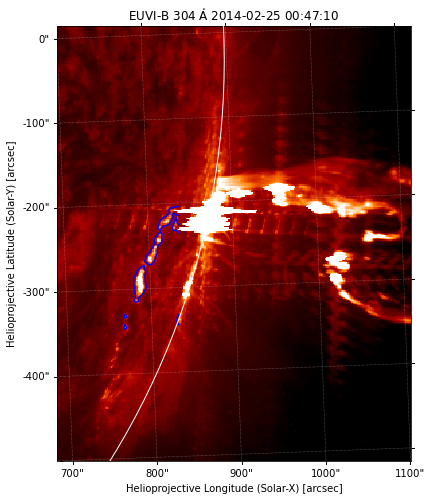

In [388]:
submap_euvi = map_euvi.submap(SkyCoord(700*u.arcsec, -500*u.arcsec, frame=map_euvi.coordinate_frame), 
                            top_right=SkyCoord(1100*u.arcsec, 0*u.arcsec, frame=map_euvi.coordinate_frame))
submap_euvi.plot(clip_interval=(1, 99.5)*u.percent)
submap_euvi.draw_limb()
# submap_euvi.draw_rectangle(bl_2, top_right=tr_2)

ax = plt.gca()
for c in contours:
    ax.plot_coord(c, color="b")

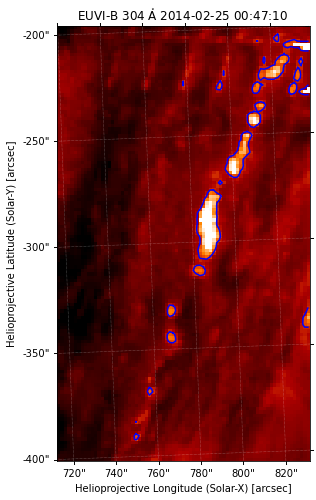

In [420]:
bl_2 = SkyCoord(720*u.arcsec, -400*u.arcsec, frame=submap_euvi.coordinate_frame)
tr_2 = SkyCoord(830*u.arcsec, -200*u.arcsec, frame=submap_euvi.coordinate_frame)
submap_euvi2 = submap_euvi.submap(bl_2, top_right=tr_2)
submap_euvi2.plot()
ax = plt.gca()
contours = submap_euvi2.contour(0.2*submap_euvi2.data.max())
for c in contours:
    ax.plot_coord(c, color="b")

In [421]:
contours = [SkyCoord(c) for c in contours]

In [422]:
contours2 = [c.transform_to(submap_aia.coordinate_frame) for c in contours]

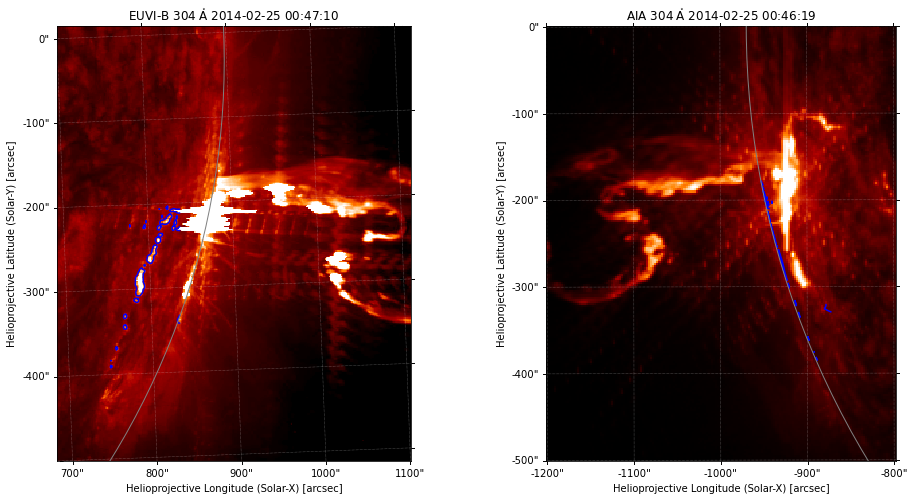

In [431]:
fig = plt.figure()
ax1 = plt.subplot(1,2,1, projection=submap_euvi)
ax2 = plt.subplot(1,2,2, projection=submap_aia)


submap_euvi.plot(axes=ax1, clip_interval=(1, 99.5)*u.percent)
submap_euvi.draw_limb(axes=ax1, color="grey")
for c in contours:
    ax1.plot_coord(c, color="blue")

submap_aia.plot(axes=ax2, clip_interval=(1, 99.5)*u.percent)
submap_aia.draw_limb(axes=ax2, color="grey")
for c in contours2:
    ax2.plot_coord(c, color="blue")

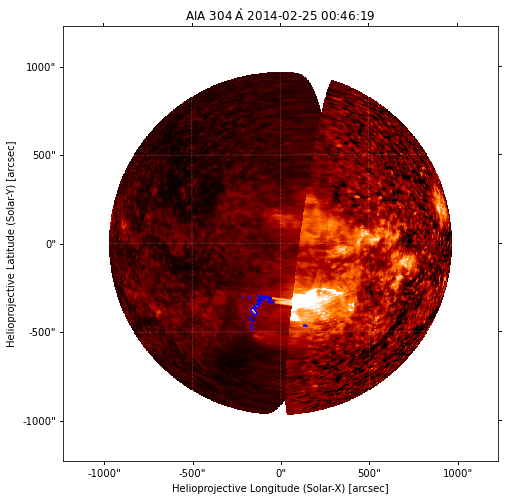

In [429]:
outmap_full.plot(clip_interval=(1, 99.5)*u.percent)
contours3 = [c.transform_to(outmap_full.coordinate_frame) for c in contours]
ax = plt.gca()
for c in contours3:
    ax.plot_coord(c, color="b")

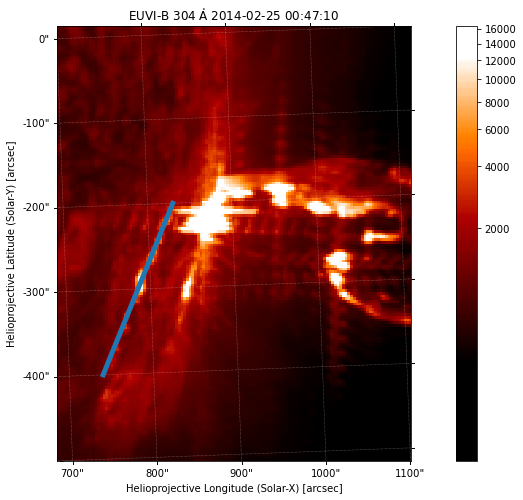

In [274]:
x = np.linspace(740, 830, 100)
y = np.linspace(-400, -200, 100)
testy = SkyCoord(x*u.arcsec, y*u.arcsec, frame=submap_euvi.coordinate_frame)

submap_euvi.plot()
plt.colorbar()
ax = plt.gca()
ax.plot_coord(testy, lw=5)



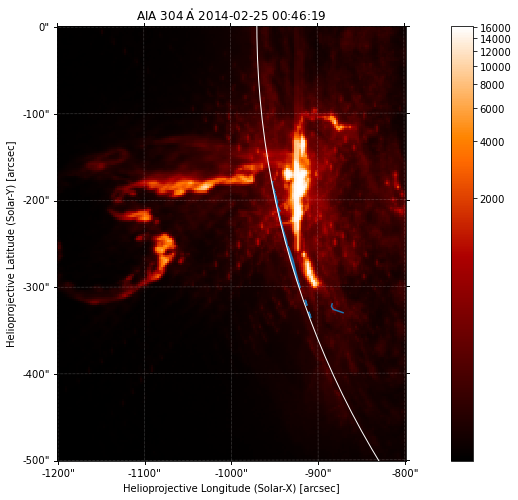

In [301]:
testy_aia = testy.transform_to(submap_aia.coordinate_frame)

submap_aia.plot()
plt.colorbar()
ax = plt.gca()

submap_aia.draw_limb(zorder=2)
# ax.plot_coord(testy_aia, color="tab:blue", lw=5)

for c in contours2:
    ax.plot_coord(c, color="tab:blue")

In [169]:
point_aia = SkyCoord(-1200*u.arcsec, -250*u.arcsec, frame=map_aia.coordinate_frame)

point_stereo = point_aia.transform_to(map_euvi.coordinate_frame)
print(point_stereo)

<SkyCoord (Helioprojective: obstime=2014-02-25T00:47:10.766, rsun=695700000.0 m, observer=<HeliographicStonyhurst Coordinate (obstime=2014-02-25T00:47:10.766): (lon, lat, radius) in (deg, deg, m)
    (-160.13335741, 7.23745837, 1.59780991e+11)>): (Tx, Ty, distance) in (arcsec, arcsec, m)
    (nan, nan, nan)>


In [170]:
point_stereo.distance

<Distance nan m>

In [171]:
print(point_aia)

<SkyCoord (Helioprojective: obstime=2014-02-25T00:46:19.120, rsun=696000000.0 m, observer=<HeliographicStonyhurst Coordinate (obstime=2014-02-25T00:46:19.120): (lon, lat, radius) in (deg, deg, m)
    (-0.01103429, -7.16154077, 1.48070742e+11)>): (Tx, Ty) in arcsec
    (-1200., -250.)>


In [172]:
map_aia.observer_coordinate.radius

<Distance 1.48070742e+11 m>

In [173]:
point_aia.observer.radius

<Distance 1.48070742e+11 m>

In [193]:
? map_aia.draw_rectangle